# <div align="center">Project 2a: Correlation Power Analysis (CPA) - Data Acquisition<div>

<p><div align="center">Due Date: Saturday March 27th, 2021, 11:59 PM</div></p>

<div align="center"><b>You are expected to work in groups of two. Address all questions listed in this document in your final report. Submit the report on <a href="https://mymasonportal.gmu.edu" target="_blank">MyMason</a> in PDF format.</div>

Correlation Power Analysis (CPA) is a variant of power side channel analysis that collects many power traces while the device under test (DUT) is performing a cryptographic operation. The attacker selects an attack point where an intermediate value is calculated in the device. The intermeadiate value should be a function of known data (e.g. plaintext) and a small portion of the key.
The attacker uses all possible values of the key portion to calculate the possible values of the intermediate. A power model (e.g. Hamming weight or distance) is used to calculate values proportional to the power consumption of the device when the device computes the intermediate. These values are called the hypothetical power.
The real power traces collected are statistically correlated with the hypothetical power to find the key portion most likley used in the crypto operation.

In this project, you will be using [FOBOS 3](https://cryptography.gmu.edu/fobos/), the soon to be released latest version of FOBOS, to perform a Correlation Power Analysis (CPA) attack on an FPGA implementation of the Advanced Encryption Standard (AES).

FOBOS stands for *Flexible Open-sources workBench fOr Side-channel analysis* and was developed by the [Cryptographic Engineering Research Group (CERG)](https://cryptography.gmu.edu) at GMU. FOBOS, loosely named after the Greek god Phobos (φóβoς) who personifies fear and can pierce shields, was designed to be an inexpensive side channel analysis setup that includes a complete software package with programs for device under test (DUT) control, data acquisition and data analysis. In order to evaluate side-channel leakage of hardware platforms, FOBOS uses off-the shelf FPGA boards as
control and victim which are less expensive than the traditional setup. FOBOS3 adds a data acquisition board designed by CERG with an Analog to Digital Converver (ADC) which enables measurements of power consumption and replaces the oscilloscope of traditional setups. Communication with the PC is now handled via Ethernet.

For this lab we provide Internet access to a Side-Channel Analysis setup composed of the following components:

1. **SCA workstation**: This is the machine that you are currently running this Jupyter notebook on. The SCA workstation runs all capture and analysis scripts. To collect traces, you run a script that connects to the control board via network, sends test vectors, comprised of plaintext and key, one at a time, and receives results (ciphertext) and traces back from the control board. Results and traces are stored in files in the SCA workstation for further analysis.

2. **FOBOS3 control board**: Receives test vectors from the SCA workstation and forwards them to the DUT. Once the DUT starts processing a test vector (running the crypto algorithm), the control board collects the instantaneous power consumption changes of the DUT using a current probe. The control board also generates the clock signal for the DUT and controls the trigger signal (used to trigger ADC / oscilloscope to collect a trace)

2. **DUT board**: Here we instantiate the crypto core (a.k.a victim: AES-128) which we want to attack. We need to measure the power consumption of this board. We have a Digilent Nexys 3 board (which contains a Xilinx Spartan6 FPGA) as a DUT board.

The picture below shows the FOBOS 3 setup in the CERG lab. On the left is the *FOBOS Control* board comprised of a *Xilinx PYNQ* system on chip FPGA board and the *FOBOS Shield* data acquisition board with an ADC for power measurements. *FOBOS Control* is connected via a ribbon cable and the *FOBOS Multitarget Connector (MTC)* to the *Device under Test (DUT)* on the right of the picture. The DUT gets the core voltage for the FPGA from a *lab power supply*. The core voltage passes through a *Current Probe*, so that changes in the current consumption of the DUT can be measured by the ADC on the *FOBOS Shield*. The SCA workstation hosts this jupyter notebook and talks to *Fobos Control* via a *Network Interface*.
![FOBOS 3 Lab Setup](figures/FOBOS3-lab-setup.jpg "FOBOS 3 Lab Setup")

## Getting Familiar with JupyterLab

To the left of this text is a file manager. You have already used it to navigate to this worksheet. Explore the directory structure. 

<div class="alert alert-block alert-info">

#### Questions:
1. What files do you find in the *fobosworkspace* folder? Write down the file names and the directory they are in.
    
2. One file is a text file, double click to open it and write down its file name and contents.
    
</div>

The directory <code>figures</code> contains the pictures shown in this worksheet, and the directory <code>foboslib</code> contains the fobos library functions.

To the left of the directory tree is a list of symbols starting with the **folder symbol** on top. Click on this when you want to return to the file manager. 

The **square in a circle symbol** below shows an overview of open tabs and running kernels. Each time you open a Jupyter Notebook, a kernel is started. The kernel is what executes the python code in the worksheet. The kernel keeps on running, when you log out and even when you close the Notebook tab. When you log in again or open the worksheet again, you can continue the work where you left of as the kernel kept on running and the state, i.e. values assigned to variables, etc, was preserved. When you are done with the work, please shut down the kernel. The kernel is automatically started when you open the worksheet again or execute a pyton cell in a worksheet.

The next symbol is the **3 dots with lines symbol**. It shows the table of contents of the current worksheet. You can use this to quickly navigate the worksheet. This is very useful for long worksheets like this one.

Using the symbols right above this worksheet you can save your worksheet, insert, cut copy, and paste cells from the worksheet, execute a cell i.e. run the python code in the cell, stop or restart the kernel. In order to execute the code in a cell, and at the same time move from one cell to another you can also press <code>Shift</code>-<code>Enter</code> on your keyboard. Restarting a kernel is sometimes necessary when the kernel hangs.

## Side Channel Analysis Process

### Step 1: Point of Attack and Power Model

First we need to choose a point during the run time of the crypto algorithm in which we want to attack, i.e., the *Attack Point*. We choose it to be the point in time where an intermediate result is computed as a funcion of a known data value and the key. The intermediate value is calculated as *f(d, k)* where *d* is a known non-constant value that can be derived from known data, typically plaintext or ciphertext, and *k* is small part of the key. 

AES applies four different transformations, SubBytes, ShiftRows, MixColumns, and AddRoundKey, per round and iterates through several such rounds depending upon the key size. An intermediate key called "round key" is generated and used per round which is derived from the original key through a reversible key scheduling function. We have implemented a basic iterative architecture of AES with 128-bit key length and 128-bit wide datapath requiring 11 clock cycles for one encryption. Key scheduling is done on-the-fly and the SubBytes function is realized through look-up-tables. The image below shows the block diagram of the AES-128 that we attack in this project. 

![AES Block Diagram](figures/aes128.png "AES Block Diagram")

We attack our AES design during the **first round** at the output of the state register FF1 as indicated in the figure above. A change in values at the output of FF1 leads to power being consumed by the linear ShiftRows, MixColumns, and AddRoundKey functions, as well as by the non linear S-Box. 

During round 11 of encrypting plaintext $PT_i$, i.e. the last round of AES, the AES state in FF1 goes through the ShiftRows function, skipps MixColumns, and continues through AddRoundKey to produce the ciphertext $CT_i$ at the input of the output register FF2. At the same time, $CT_i$ also propagates through SubBytes to FF1. FF1 stores the value of $SBOX(CT_i)$.

The next clock cycle is the 1st round of encrypting plaintext $PT_{i+1}$. A new plaintext block is inputed, goes through AddRoundKey, SubBytes and to FF1. Now FF1 stores the value of 
$f(d_i,k)=SBOX(PT_{i+1} \oplus k)$.

As we know the output of FF1 during two consecutive clock cycles of AES, we can use the Hamming Distance Model to model the power consumption. We compute the hypothetical power model for each key guess $k_j$ and for all data values $d_i$, i.e., for all plaintext that we try using the Hamming Distance (HD) equation below. This equation is directly derived from the equations we determined above for the output of FF1 during 2 consecutive clock cycles.

\begin{equation}
h(i,j) = HD(SBOX(CT_i), SBOX(k_j \oplus PT_{i+1} ))
\end{equation}

We use the HD model since it is suitable for CMOS technology and we know the the value of the intermediate at the attack point on two consecutive clock cycles.
    
The attack will be performed in Step 4, one key byte at a time. However, now that we know during which round we attack we can make sure that we acquire power measurements for the "interesting" clock cycles, i.e. the first clock cycle of AES.


### Step 2: Data Acquisition - Power Measurements

We measure the power consumption of the crypto device (DUT) while it encrypts $D$ data blocks. We need to know the value $d$ that corresponds to each data block. These values can be written as a vector $\mathbf{d} = [d_1, d_2, \ldots, d_D]$. 
A single power measurement value obtained from an oscilloscope or ADC is called a sample.
All samples collected during the encryption or decryption of a single data block comprise a trace.
The trace generated while encrypting or decrypting a data block $d_i$ consists of $T$ samples and can be viewed as a vector $\mathbf{t}_i = [t_{i,1}, t_{i,2}, \ldots, t_{i,T}]$.
The traces are stacked in a matrix $\mathbf{T}$ with dimensions $D \times T$ where each row $i$ is a trace generated while encrypting or decrypting block $d_i$.


### Step 3: Calculating Hypothetical Power
This step will be performed in Project 2 part b).

### Step 4: Data Analysis

This step will be performed in Project 2 part b).

## FOBOS Acquisition Configuration

The block of python code below this cell loads all libraries FOBOS requires and configures FOBOS for data acquisition. We now examine each section of the code.

### Connection to Control Board

This setup uses a Xilinx Pynq board as FOBOS3 Control board. Pynq contains a Xilinx Zynq 7020 System on Chip which in turn consists of a dual core ARM processor running Linux and an FPGA. FOBOS uses the FPGA for generating a clock signal for the DUT, communicating with the DUT, and collecting measurements from the ADC on the FOBOS Shield. The SCA workstation talks to the Pynq board via TCP/IP. 
  
### Files and Locations:

FOBOS uses a **workspace** folder, typically called <code>fobosworkspace</code>, to store projects. 
A project is an experiment, in which a user tries to assess the vulnerability of a cipher to an SCA attack. 
Each project has a **projectName** which is also the name of the directory inside the workspace in which FOBOS stores all files pertaining to this project. As we are attacking an implementation of AES, we simply name it <code>aes</code>. You can change it though to anything you like as long as its a valid Linux directory name. FOBOS expects the following configuration files inside the project directory:

- **keyFile**   <code>key.txt</code> contains the key we want to use. 
- **bitFile**   <code>half_duplex_dut.bit</code> contains the bitstream needed to program the DUT FPGA with the algorithm under test.

Before we can run an attack, we have to generate test vectors that the FOBOS DUT understands. We will use a script that generates plaintext randomly and creates test vectors from the plaintext and the key. FOBOS needs to know the filenames we want to use for plaintext and test vectors.

- **plainFile** <code>plaintext.txt</code> contains one plaintext block for AES per line.
- **dinFile**   <code>dinFile.txt</code> contains test vectors in FOBOS format that will be send to the DUT. These testvectors contain the plaintext as well as the key. It was created using the script blockCipherTVGen.py (not provided). This script also generated <code>plaintext.txt</code>.

FOBOS creates a directory called <code>capture</code> inside the project folder. Each time you run test vectors and measure traces, a new folder <code>attempt-</code>*number* is created inside the <code>capture</code> directory. It will contain a copy of the <code>dinFile.txt</code> and the <code>plaintext.txt</code> files as well as the output files:

- **cipherFile** <code>ciphertext.txt</code> contains the ciphertext that the cipher generated from the test vectors.
- **traceFile**  <code>powerTraces.npy</code> contains the ADC / oscilloscope measurements for all traces in numpy format.

### Cipher Specific Information

Last, FOBOS needs to know some information about the cipher we want to attack, namely how big its input block size, output block size, and key size are. All numbers are to be given in bytes.

<div class="alert alert-block alert-info">

#### Questions:

3. In the code below, set the block size of the plaintext **blockSize**, ciphertext **cipherSize**, and key **keySize** for AES. We are attacking an AES implementation with a 128-bit key. Remember to specify the sizes in term of bytes, not bits!
Leave all the other parameters at the default settings.
</div>


Run the following cell (Shift + Enter) to import libraries needed for the capture software and configure input and output files.



In [1]:
# import libraries
# import os
# import sys
# import shutil
# import json
# import numpy as np
# import foboslib.pynqctrl
# from foboslib.fobosctrl import FOBOSCtrl
# from foboslib.fobosTVGen import FobosTVGen
# import foboslib.projmgr
# import foboslib.nexys3dut

#######################################################
import os
import sys
import shutil
import json
from foboslib.ctrl import pynqctrl
from foboslib.ctrl.fobosctrl import FOBOSCtrl
import foboslib.projmgr
import numpy as np
from foboslib.dut import cw305dut
from foboslib.fobosTVGen import FobosTVGen

#######################################################
# Acquisition Configuration
acqConf = {}
# Connection to Control Board
acqConf['ip'] = '192.168.10.99'
acqConf['port'] = 9995
# File Names and Locations
acqConf['workspace'] = "fobosworkspace"     # Folder to store projects
acqConf['projectName'] = "aes"              # Name of this project. Files will be in workspace/projectName/
acqConf['keyFile'] = "key.txt"              # key used for encryption / decryption
acqConf['bitFile'] = "half_duplex_dut.bit"  # Bitstream for programming the DUT (target) 
acqConf['plainFile'] = "plaintext.txt"      # plaintext in hex
acqConf['dinFile'] = "dinFile.txt"          # test vectors in FOBOS format incl. plaintext and key
acqConf['cipherFile'] = "ciphertext.txt"    # observed ciphertext, result from applying test vectors
acqConf['traceFile']  = "powerTraces.npy"   # Name of file for recording power traces
# Cipher Specific Information
acqConf['blockSize'] =  16                    # size of a block of plaintext in bytes
acqConf['cipherSize'] =  16                   # size of a block of ciphertext in bytes
acqConf['keySize'] =  16                      # size of the key in bytes

### Acquisition Settings:

The next thing we have to configure are the specifics for the test. This includes the number of traces we want to run, how fast the DUT clock should run, the oscilloscope configuration, and what the output length of the cipher is.

- **traceNum** is the number of traces we want to run. As we are still fine tuning the other parameters, we should start with a small number, e.g. 10.
- **DUTclk** is the clock frequency of the device under test in MHz. Slow clock frequencies lead to a cleaner signal, hence we typically run at 1 MHz.
- **samplingFreq** specifies how fast the oscilloscope should sample (measure) the power consumption. The unit is Msps which stands for Million samples per second.
- **samplesPerTrace** tells the oscilloscope after how many samples it should stop recording for each trace.
- **ADCgain** specifies the how much the signal from the power probe should be amplified. The goal is to have a signal use most of the range between 0..1023 as our ADC has a 10-bit resolution. If the sginal gets clipped, i.e. has straight lines on top at 1023 or bottom at 0, the gain was too high and has to be reduced. Please be careful when changing this parameter.


<div class="alert alert-block alert-info">

#### Questions:

4. In the code below, set the DUT clock frequency **DUTclk** to 1 MHz and oscilloscope sampling frequency **samplingFreq** to 50 Msps. How many samples will be collected every DUT clock cycle?
5. If you want to collect the entire AES encryption process for one test vector (one block), what is the number of samples you need to collect. (Hint : This implemetation needs first 4 clock cycles to load data + 11 clock cycles to finish the AES encryption). Using the number of samples you calculated, set the **samplesPerTrace** in the script. Leave all the other parameters at the default settings.
</div>

After you finish the configuration, run the following cell.

In [2]:
#Acquistion configuration
acqConf['traceNum'] = 10             # number of traces to run [default: 10]
acqConf['DUTClk'] = int(1000 * 1.6)          # clock frequency of the DUT in MHz, [range: 1 - 100]
acqConf['samplingFreq'] =  50 * 1.6  # sampling frequency of the Oscilloscope in Msps [default: 50][range: 1 - 100]
acqConf['samplesPerTrace'] =  1000   # number of sample in one trace [range: 1 - 2^17]
acqConf['ADCGain'] = 40              # amplification of ADC input signal [default: 40][range: 0 - 60]

### Generating Test Vectors

The following commands generate a file with as many plaintext blocks containing random values as we want to record traces. It then uses them and the key to generate test vectors in FOBOS format. You only have to re-run this cell, if you changed the number of traces you want to run, or if you want to try the attack with new data.

In order to examine the contents of the plaintext file, traverse the directory tree on the left to *fobosworkspace/aes* and double-click <code>plaintext.txt</code>. This will open a new tab with the contents of this file.

In [3]:
# Configure project directories
pm = foboslib.projmgr.ProjectManager()
pm.setWorkSpaceDir(acqConf['workspace'])
pm.setProjName(acqConf['projectName'])
projDir = pm.getProjDir()
# Generate test vectors
tvGen = FobosTVGen(traceNum=acqConf['traceNum'],
                   blockSize=acqConf['blockSize'],
                   keySize=acqConf['keySize'],
                   cipherSize=acqConf['cipherSize'],
                   dinFile= os.path.join(projDir, acqConf['dinFile']),
                   plaintextFile=os.path.join(projDir, acqConf['plainFile']),
                   keyFile=os.path.join(projDir, acqConf['keyFile'])
                   )
tvGen.generateTVs()

Generating 10 test vectors...
    KeyFile = fobosworkspace/aes/key.txt
    PlaintextFile = fobosworkspace/aes/plaintext.txt
    Block Size (bytes) = 16
    Ciphertext Size (bytes) = 16
    Key Size (bytes)= 16
Done.


<div class="alert alert-block alert-info">

#### Questions:

6. What is the value of the first block we use as input (plaintext)? 
7. How many bytes are in the block and why?
8. How many blocks does this file contain?
9. What other files does the directory *fobosworkspace/aes* now contain?
    
</div>

## FOBOS Acquisition Measurements

### Run the Measurements

The next cell runs the measurements. First, it acquires access and then connects to FOBOS test setup: "hardware". This locks the hardware while you are  using it. Once you finish the hardware is released to allow others to access it.
You should see a message saying 'Acquired hardware lock'. If the hardware is used it will wait for some time until hardware is available. If this does not work, please try again after few minutes. But **please do not interrupt this cell if it is still trying to acquire access**.

Once the hardware is accessed, the script first applies the configuration parameters you configured previously to the control board and the oscilloscope / ADC. Then it programms the FPGA of the DUT. It specifies the input and output files and creates a new folder <code>attempt-</code>number inside the <code>capture</code> directory for the output files and copies the input files <code>dinFile.txt</code> and <code>plaintext.txt</code> files into it. 

<span style="color:red">Please pay attention to the messages generated by the next cell and note the attempt-xx directory number.</span>

After all this setup, it sends the test vectors one at a time to the control board, receives the ciphertext and power traces.

Once its done, it will release the hardware lock so that other students can use it. You should see a message saying 'Released hardware lock.'.

In [4]:
ctrl = pynqctrl.PYNQCtrl(acqConf['ip'], acqConf['port'])

Waiting for current user to release hardware. Please wait ...
Acquired hardware lock


In [5]:
# connect to hardware and lock it ######################################
# Apply config to ctrl board ###########################################

ctrl.setDUTClk(acqConf['DUTClk'])
ctrl.setDUTInterface(FOBOSCtrl.INTERFACE_4BIT)
ctrl.setOutLen(acqConf['cipherSize'])
ctrl.setTriggerMode(FOBOSCtrl.TRG_FULL)
# configure trace sampling #############################################
ctrl.setSamplingFrequency(acqConf['samplingFreq'])
ctrl.setADCGain(acqConf['ADCGain'])
ctrl.setSamplesPerTrace(acqConf['samplesPerTrace'])


Setting DUT clk
	OK 	  : Set DUT clk = 1600 KHz
Setting DUT interface type
	OK 	  : Set dut interface = 0


0

In [7]:
# program DUT ##########################################################
# dut = foboslib.nexys3dut.Nexys3DUT()
# bitFile = os.path.join(projDir, acqConf['bitFile'])
# dut.setBitFile(bitFile)
# dut.program()
# prepare i/o files ####################################################
tvFileName = os.path.join(projDir, acqConf['dinFile'])
plainFileName = os.path.join(projDir, acqConf['plainFile'])
tvFile = open(tvFileName, "r")
captureDir = pm.getCaptureDir()
cipherFileName = os.path.join(captureDir, acqConf['cipherFile'])
cipherFile = open(cipherFileName, "w")
traceFileName = os.path.join(captureDir, acqConf['traceFile'])
traceFile = open(traceFileName, "a+b")
shutil.copy(tvFileName, captureDir)
shutil.copy(plainFileName, captureDir)
# save config to a file
configFile = open(os.path.join(captureDir, 'acquisitionConfig.json'), "w")
configFile.write(json.dumps(acqConf, indent=4))
#configFile.write(ctrl.config)
#print(ctrl.config)
configFile.close()
# Get traces############################################################
print('Processing test vectors ...')
traceNum = 0
while traceNum < acqConf['traceNum']:
    data = tvFile.readline()
    status, result, trace = ctrl.processData2(data, acqConf['cipherSize'])
    cipherFile.write(result + "\n")
    np.save(traceFile, trace)
    if traceNum % 100 == 0:
        sys.stdout.write('Progress:' + "{:.2f}".format(traceNum/acqConf['traceNum']*100) + '%\r')
        sys.stdout.flush()
    traceNum += 1
print('Data acquisition complete.')
ctrl.disconnect() # release and reset control board.
traceFile.close()
cipherFile.close()
tvFile.close()

Successfully created new capture directory at fobosworkspace/aes/capture/attempt-17
Processing test vectors ...
Data acquisition complete.
Released hardware lock.


### Plot and Evaluate the Measurements
The next code cell will create a graph of the measured power consumption and plot up to 100 traces on top of each other. You can adjust the size of the plot by changing the entry for <code>figsize</code>. The figure will be saved under the name <code>traces.png</code> in the <code>capture/attempt-xx</code> directory.

<Figure size 432x288 with 0 Axes>

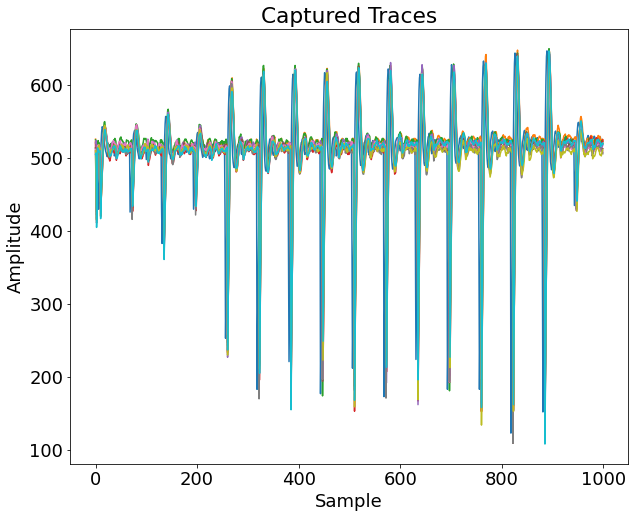

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.rcParams.update({'font.size': 18})
traceFile = open(traceFileName, "r+b")
maxtrace = 100
plt.figure(figsize=(10,8))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Captured Traces')
for i in range(min(maxtrace, acqConf['traceNum'])):
    trace = np.load(traceFile)
    plt.plot(trace)

plt.savefig(os.path.join(captureDir, 'traces.png'),facecolor=fig.get_facecolor())
# plt.close()
traceFile.close()

<div class="alert alert-block alert-info">

#### Questions:

10. What files does the *capture/attempt-xx* directory contain?
11. Now lets examine the graph. How many peaks are in the trace? 
    The first peaks are related to loading the data, which are followed by the 
    AES-128 rounds, and, if you capture enough samples, some samples for storing the data. 
12. How many peaks are you expecting for AES-128?
13. Adjust the number of **samplesPerTrace** and re-run the boxes above starting from 
    <code>#Acquisition Settings</code> until you see the wave form for the complete AES. 
    You can also carefully adjust the 
    **ADCgain** until the amplitude of the wave form fills the graph from 0 to 1023 without clipping. 
    Write the settings you used into your report.
14.  Copy the generated graph into your report and mark the peaks relating to AES indicating the round numbers.
15. Explain why the traces are not plotted precisely on top of each other but they show some variability
    (Give at least two reasons). 
16. Which range of samples corresponds to the point of attack of our power model?
17. The power trace covers the full run of AES and more. However, our power model is particular to
    the first round of the encryption. Hence, we can limit how much data we have to analyze. 
    Change the number of samples such that the acquisition ends after the second round. This will limit 
    the amount of data you'll have to analyze. Adjust the number of **samplesPerTrace** and re-run the boxes 
    above starting from <code>#Acquisition Settings</code>. Write the settings you used
    into your report. 
18. Copy the generated graph into your report.
19. In order to run a successful attack we need many more traces than 10. 
    Set the **traceNum** to 10000 and
    re-run the boxes above starting from <code>#Acquisition Settings</code>. 
    Make sure that you also re-run the test vector generation this time.
    Look in the *fobosworkspace/aes/capture/attempt-xx* directory and open *ciphertext.txt*. 
    How many bytes are in each ciphertext block and how many ciphertext
    blocks were captured?
</div>





By the end of this notebook you have the traces stored in the T matrix. We need this in the next step, project 2b, to recover the secret key used in the AES cipher!
